In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/cy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
vgsales = pd.read_csv('vgsales.csv')
video_game_sales = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
game_reviews = pd.read_csv('metacritic_critic_reviews.csv')

In [3]:
#Get the unique game names from vgsales
vgsales['Name'] = vgsales['Name'].str.lower()
unique_vgsales = vgsales.groupby(['Name','Platform']).count()
unique_vgsales.reset_index(drop = False, inplace = True)
unique_vgsales = unique_vgsales.iloc[:,0:2]
print(unique_vgsales.shape)
unique_vgsales.head()

(16593, 2)


,Name,Platform
0,'98 koshien,PS
1,.hack//g.u. vol.1//rebirth,PS2
2,.hack//g.u. vol.2//reminisce,PS2
3,.hack//g.u. vol.2//reminisce (jp sales),PS2
4,.hack//g.u. vol.3//redemption,PS2


In [4]:
#Get the unique game names from video_game_sales
video_game_sales['Name'] = video_game_sales['Name'].str.lower()
unique_video_game_sales = video_game_sales.groupby(['Name','Platform']).count()
unique_video_game_sales.reset_index(drop = False, inplace = True)
unique_video_game_sales = unique_video_game_sales.iloc[:,0:2]
print(unique_video_game_sales.shape)
unique_video_game_sales.head()

(16713, 2)


,Name,Platform
0,beyblade burst,3DS
1,fire emblem fates,3DS
2,frozen: olaf's quest,3DS
3,frozen: olaf's quest,DS
4,haikyu!! cross team match!,3DS


In [5]:
#Change the platform format in game_reviews to make them aligned with the other two tables
game_reviews.replace("PlayStation 4", "PS4", inplace=True)
game_reviews.replace("PlayStation Vita", "PSV", inplace=True)
game_reviews.replace("Wii U", "WiiU", inplace=True)
game_reviews.replace("Xbox One", "XOne", inplace=True)

In [6]:
#Get the unique game names from game_reviews
game_reviews['game'] = game_reviews['game'].str.lower()
unique_game_reviews = game_reviews.groupby(['game','platform']).count()
unique_game_reviews.reset_index(drop = False, inplace = True)
unique_game_reviews = unique_game_reviews.iloc[:,0:2]
print(unique_game_reviews.shape)
unique_game_reviews.head()

(5516, 2)


,game,platform
0,#idarb,XOne
1,.hack//g.u. last recode,PC
2,.hack//g.u. last recode,PS4
3,0rbitalis,PC
4,1-2-switch,Switch


In [7]:
#Merge game_reviews to vgsales and video_game_sales
test_merge1 = pd.merge(unique_game_reviews, unique_vgsales, left_on=['game','platform'], right_on=['Name','Platform'], how='inner')
test_merge2 = pd.merge(unique_game_reviews, unique_video_game_sales, left_on=['game','platform'], right_on=['Name','Platform'], how='inner')

In [8]:
merged_game_sale_and_reviews = pd.merge(game_reviews, video_game_sales, left_on=['game','platform'], right_on=['Name','Platform'], how='inner')
print(merged_game_sale_and_reviews.shape)
merged_game_sale_and_reviews.head()

(32779, 22)


,name,review,game,platform,score,date,Name,Platform,Year_of_Release,Genre,...,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEVEL (Czech Republic),"Portal 2 is a masterpiece, a work of art that ...",portal 2,PC,100.0,"May 25, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+
1,GameCritics,So do we need Portal 2? Do I need it? Maybe no...,portal 2,PC,100.0,"May 8, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+
2,PC Games (Russia),Portal 2 exceeds every expectation. It has a s...,portal 2,PC,100.0,"May 6, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+
3,Adventure Gamers,"Like its predecessor, Portal 2 is not an adven...",portal 2,PC,100.0,"Apr 29, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+
4,Armchair Empire,"Pile on the ""Oh, yes!"" moments of solving some...",portal 2,PC,100.0,"Apr 28, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+


## Embeddings section¶
Some parts of this section are from the article in the link below.

https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61

The author demonstrates how to retrieve embeddings from the IMDB reviews.

In [11]:
#Clean the reviews first
merged_game_sale_and_reviews['review_tokens'] = merged_game_sale_and_reviews['review'].str.lower()
merged_game_sale_and_reviews['review_tokens'] = merged_game_sale_and_reviews['review_tokens'].apply(word_tokenize)
merged_game_sale_and_reviews.head()

,name,review,game,platform,score,date,Name,Platform,Year_of_Release,Genre,...,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,review_tokens
0,LEVEL (Czech Republic),"Portal 2 is a masterpiece, a work of art that ...",portal 2,PC,100.0,"May 25, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[portal, 2, is, a, masterpiece, ,, a, work, of..."
1,GameCritics,So do we need Portal 2? Do I need it? Maybe no...,portal 2,PC,100.0,"May 8, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[so, do, we, need, portal, 2, ?, do, i, need, ..."
2,PC Games (Russia),Portal 2 exceeds every expectation. It has a s...,portal 2,PC,100.0,"May 6, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[portal, 2, exceeds, every, expectation, ., it..."
3,Adventure Gamers,"Like its predecessor, Portal 2 is not an adven...",portal 2,PC,100.0,"Apr 29, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[like, its, predecessor, ,, portal, 2, is, not..."
4,Armchair Empire,"Pile on the ""Oh, yes!"" moments of solving some...",portal 2,PC,100.0,"Apr 28, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[pile, on, the, ``, oh, ,, yes, !, '', moments..."


In [12]:
merged_game_sale_and_reviews['review_tokens'][0]

['portal',
 '2',
 'is',
 'a',
 'masterpiece',
 ',',
 'a',
 'work',
 'of',
 'art',
 'that',
 'you',
 'will',
 'love',
 'for',
 'its',
 'ingenious',
 'story',
 'pop-culture',
 ',',
 'references',
 'to',
 'logical',
 'puzzles',
 'and',
 'co-op',
 'multiplayer',
 '.',
 'definitely',
 'a',
 'candidate',
 'for',
 'game',
 'of',
 'the',
 'year',
 '.',
 '[',
 'issue',
 '#',
 '204',
 ']']

In [13]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in merged_game_sale_and_reviews['review_tokens'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed: ', j)

Number of texts processed:  32779


In [14]:
d2v_model = Doc2Vec(all_content_train, vector_size=3, window=4, min_count=1, workers=4)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10)

In [15]:
# tagged_reviews = [TaggedDocument(review, [i]) for i, review in enumerate(merged_game_sale_and_reviews['review_tokens'])]
# model = Doc2Vec(tagged_reviews, vector_size=50, window=2, min_count=1, workers=4)

In [16]:
d2v_model.dv[32778]

array([-0.14786857,  0.04395154,  0.50522155], dtype=float32)

In [17]:
x_train = d2v_model.dv[0].reshape(1,-1)
for i in range(1,j):
    x_train = np.append(x_train, d2v_model.dv[i].reshape(1,-1),axis=0)

x_train.shape

(32779, 3)

In [18]:
#Do K-means clustering from the Doc2Vec features
kmeans = KMeans(n_clusters=5, random_state=12345).fit(x_train)
kmeans_labels = kmeans.labels_
kmeans_labels.shape

(32779,)

In [19]:
#Do Truncate SVD for see the clusters in 2D space
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=12345)
transformed_unigrams = svd.fit_transform(x_train)
transformed_unigrams[:5]

array([[ 0.25224653,  0.12626365],
       [ 0.02765432,  0.44714296],
       [ 0.22456881, -0.06979897],
       [ 0.9885682 ,  0.0847482 ],
       [ 0.40427992, -0.1757886 ]], dtype=float32)

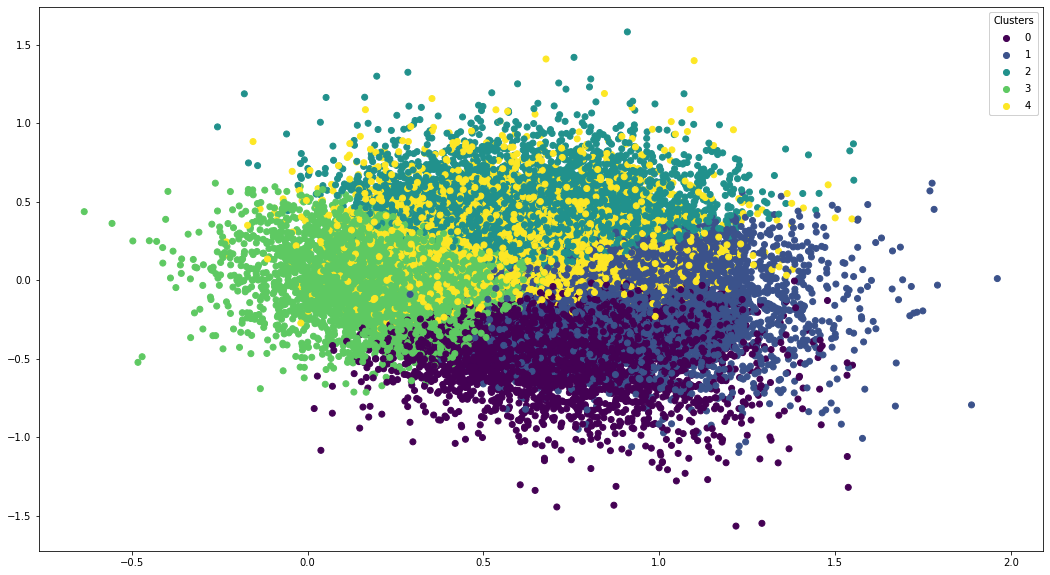

In [20]:
#Visualize the clusters
x = transformed_unigrams[:,0]
y = transformed_unigrams[:,1]
#colors = cm.rainbow(np.linspace(0, 1, y.shape[0]))
fig, ax = plt.subplots(figsize=(18,10))
scatter = ax.scatter(x, y, c=kmeans_labels)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.show()

In [21]:
#Evaluate density of the clusters, Mean Silhouette Score
silhouette_score(x_train, kmeans_labels)

#Negative value indicates wrong clustering
#Near zero indicates overlapping clusters
#The best is near 1
#The calculation involves the distance between each sample in the same cluster
#And it also involves the distance between a sample and other samples in the next nearest cluster

0.22664787

## Numerical Analysis

In [23]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import operator
import string
import itertools
import operator
import re

from sklearn import preprocessing

In [22]:
merged_game_sale_and_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32779 entries, 0 to 32778
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             32779 non-null  object 
 1   review           32779 non-null  object 
 2   game             32779 non-null  object 
 3   platform         32779 non-null  object 
 4   score            32591 non-null  float64
 5   date             32751 non-null  object 
 6   Name             32779 non-null  object 
 7   Platform         32779 non-null  object 
 8   Year_of_Release  32552 non-null  float64
 9   Genre            32779 non-null  object 
 10  Publisher        32701 non-null  object 
 11  NA_Sales         32779 non-null  float64
 12  EU_Sales         32779 non-null  float64
 13  JP_Sales         32779 non-null  float64
 14  Other_Sales      32779 non-null  float64
 15  Global_Sales     32779 non-null  float64
 16  Critic_Score     30937 non-null  float64
 17  Critic_Count

In [27]:
def year_label(x):
    x_label='1980-1985'
    if x>=1985 and x<1990:
        x_label='1985-1990'
    elif x>=1990 and x<1995:
        x_label='1990-1995'
    elif x>=1995 and x<2000:
        x_label='1995-2000'
    elif x>=2000 and x<2005:
        x_label='2000-2005'
    elif x>=2005 and x<2010:
        x_label='2005-2010'
    elif x>=2010 and x<2015:
        x_label='2010-2015'
    elif x>=2015:
        x_label='2015-2020'
    return x_label

<AxesSubplot:title={'center':'Global_Sales'}, xlabel='[year_label]'>

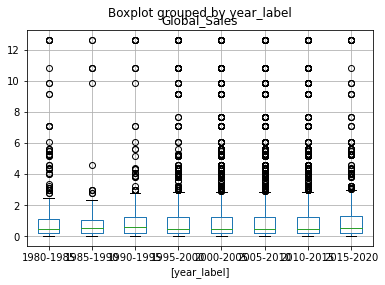

In [28]:
#Deal wiht the year information and add year label for every 5 years interval between 1980 and 2020
#merged_game_sale_and_reviews['released_years'] = 2020-video_game_sales['Year_of_Release']
merged_game_sale_and_reviews['year_label']=video_game_sales['Year_of_Release'].apply(year_label)
merged_game_sale_and_reviews.boxplot(column=['Global_Sales'], by=['year_label'])

<AxesSubplot:>

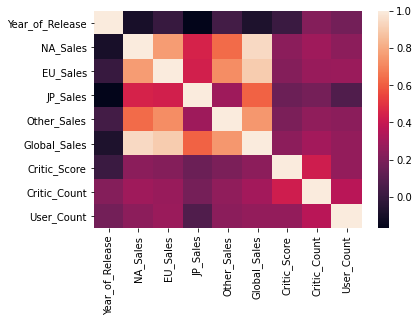

In [29]:
#get the correlation matrix heatmap for scaled numerical variables
video_game_sales_num = video_game_sales[video_game_sales.select_dtypes(include=np.number).columns.tolist()]
min_max_scaler=preprocessing.MinMaxScaler()
video_game_sales_scaled=pd.DataFrame(min_max_scaler.fit_transform(video_game_sales_num))
video_game_sales_scaled.columns=video_game_sales_num.columns
sns.heatmap(video_game_sales_scaled.corr())

<AxesSubplot:>

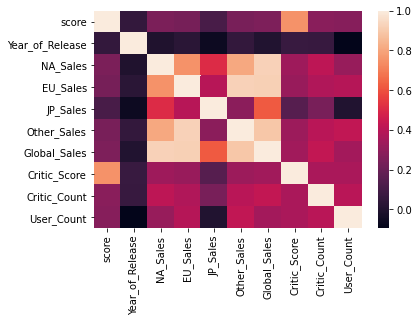

In [42]:
#get the correlation matrix heatmap for scaled numerical variables
merged_game_sale_and_reviews_num = merged_game_sale_and_reviews[merged_game_sale_and_reviews.select_dtypes(include=np.number).columns.tolist()]
#min_max_scaler=preprocessing.MinMaxScaler()
merged_game_sale_and_reviews_scaled=pd.DataFrame(min_max_scaler.fit_transform(merged_game_sale_and_reviews_num))
merged_game_sale_and_reviews_scaled.columns=merged_game_sale_and_reviews_num.columns
sns.heatmap(merged_game_sale_and_reviews_scaled.corr())

In [41]:
merged_game_sale_and_reviews_num.columns

Index(['score', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales',
       'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count',
       'User_Count'],
      dtype='object')

In [30]:
video_game_sales_scaled.corr()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
Year_of_Release,1.000000,-0.092562,0.003842,-0.168386,0.037700,-0.076433,0.011411,0.223407,0.175339
NA_Sales,-0.092562,1.000000,0.765336,0.449598,0.638654,0.941010,0.240755,0.295413,0.246429
EU_Sales,0.003842,0.765336,1.000000,0.435068,0.722796,0.901239,0.220752,0.277533,0.283360
JP_Sales,-0.168386,0.449598,0.435068,1.000000,0.291096,0.612300,0.152593,0.180219,0.075638
Other_Sales,0.037700,0.638654,0.722796,0.291096,1.000000,0.749242,0.198554,0.251639,0.238982
Global_Sales,-0.076433,0.941010,0.901239,0.612300,0.749242,1.000000,0.245471,0.303571,0.265012
Critic_Score,0.011411,0.240755,0.220752,0.152593,0.198554,0.245471,1.000000,0.425504,0.264376
Critic_Count,0.223407,0.295413,0.277533,0.180219,0.251639,0.303571,0.425504,1.000000,0.362334
User_Count,0.175339,0.246429,0.283360,0.075638,0.238982,0.265012,0.264376,0.362334,1.000000


<AxesSubplot:>

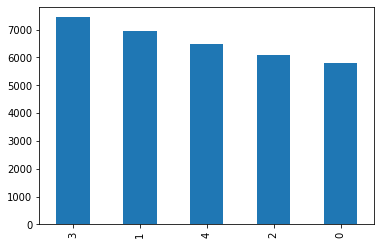

In [36]:
pd.Series(kmeans_labels).value_counts().plot.bar()

In [76]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import silhouette_score

In [54]:
merged_game_sale_and_reviews_scaled['group_label']=pd.Series(kmeans_labels)
#pd.concat([merged_game_sale_and_reviews_scaled, y_train])
#merged_game_sale_and_reviews_scaled.isnull()
merged_game_sale_and_reviews_scaled_train=merged_game_sale_and_reviews_scaled.dropna()

In [57]:
# Univariate Selection
y_train=merged_game_sale_and_reviews_scaled_train['group_label']
X_train=merged_game_sale_and_reviews_scaled_train.drop(['group_label'],axis=1)
fs = SelectKBest(score_func=f_classif, k='all')
XSelected_fit = fs.fit(X_train, y_train)

dfscores = pd.DataFrame(XSelected_fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
featureScore_uni = pd.concat([dfcolumns, dfscores], axis=1)
featureScore_uni.columns = ['Specs', 'Score']
featureScore_uni.sort_values(['Score'], ascending=False).reset_index()
#X_Select1= featureScore_uni.nlargest(, 'Score').reset_index()
#X_Select1

,index,Specs,Score
0,0,score,198.192905
1,7,Critic_Score,95.301719
2,6,Global_Sales,28.704375
3,2,NA_Sales,27.776922
4,3,EU_Sales,24.890756
5,5,Other_Sales,23.912125
6,8,Critic_Count,18.205802
7,9,User_Count,15.927453
8,1,Year_of_Release,9.970861
9,4,JP_Sales,8.904052


In [69]:
merged_game_sale_percent=merged_game_sale_and_reviews.filter(regex='Sales$', axis=1)
merged_game_sale_percent['NA_Sales']=merged_game_sale_percent['NA_Sales']/merged_game_sale_percent['Global_Sales']
merged_game_sale_percent['EU_Sales']=merged_game_sale_percent['EU_Sales']/merged_game_sale_percent['Global_Sales']
merged_game_sale_percent['JP_Sales']=merged_game_sale_percent['JP_Sales']/merged_game_sale_percent['Global_Sales']
merged_game_sale_percent['Other_Sales']=merged_game_sale_percent['Other_Sales']/merged_game_sale_percent['Global_Sales']

/Users/cy/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/cy/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cy/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [71]:
merged_game_sale_percent

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,0.434211,0.421053,0.0,0.131579,0.76
1,0.434211,0.421053,0.0,0.131579,0.76
2,0.434211,0.421053,0.0,0.131579,0.76
3,0.434211,0.421053,0.0,0.131579,0.76
4,0.434211,0.421053,0.0,0.131579,0.76
...,...,...,...,...,...
32774,0.000000,1.000000,0.0,0.000000,0.01
32775,0.000000,1.000000,0.0,0.000000,0.01
32776,0.000000,1.000000,0.0,0.000000,0.01
32777,0.000000,1.000000,0.0,0.000000,0.01


In [78]:
kmeans_kwargs={
    'init':'random',
    'n_init':10,
    'max_iter': 300,
    'random_state':42
}

silhouette_coefficients=[]
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(merged_game_sale_percent)
    score = silhouette_score(merged_game_sale_percent, kmeans.labels_)
    silhouette_coefficients.append(score)

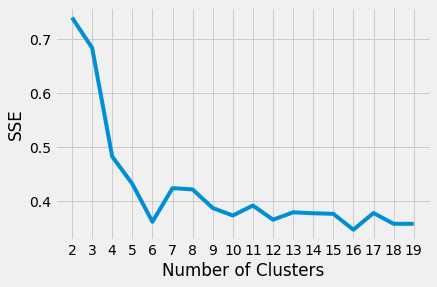

In [79]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()